<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Sarima Rossmann Lab

---

In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [7]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## Load the data

In [8]:
df = pd.read_csv('../../../../resource-datasets/rossmann_stores/rossmann.csv')
# Set the DateTime index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

/Users/Noah/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [9]:
df.dtypes

Store             int64
DayOfWeek         int64
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

## Subset the data on `Store==1` and `Open==1`

The time series we want to predict is the `Sales` column.
Plot the time series.

In [11]:
df = df[(df['Store']==1) & (df['Open']==1)]

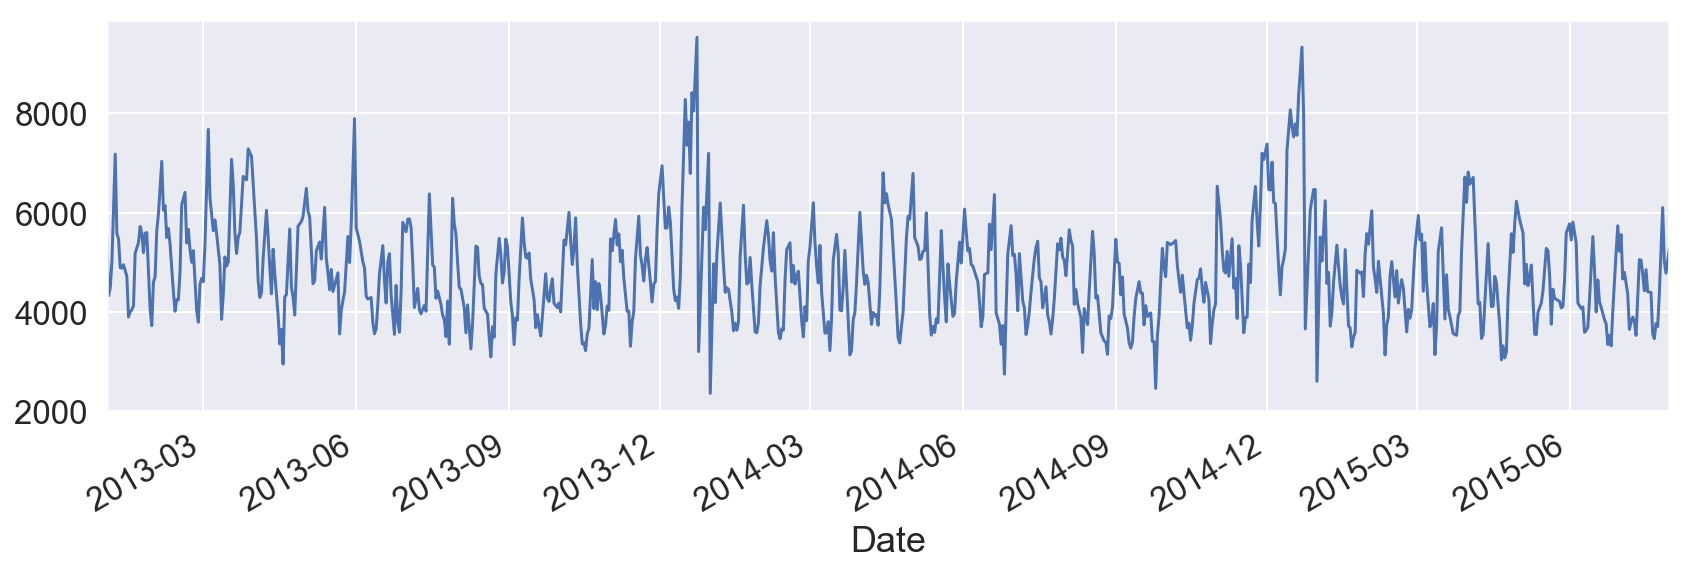

In [17]:
fig, ax = plt.subplots(figsize=(14,4))
df['Sales'].plot();

## Decompose the time series

In [15]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


In [29]:
df.shape

(781, 8)

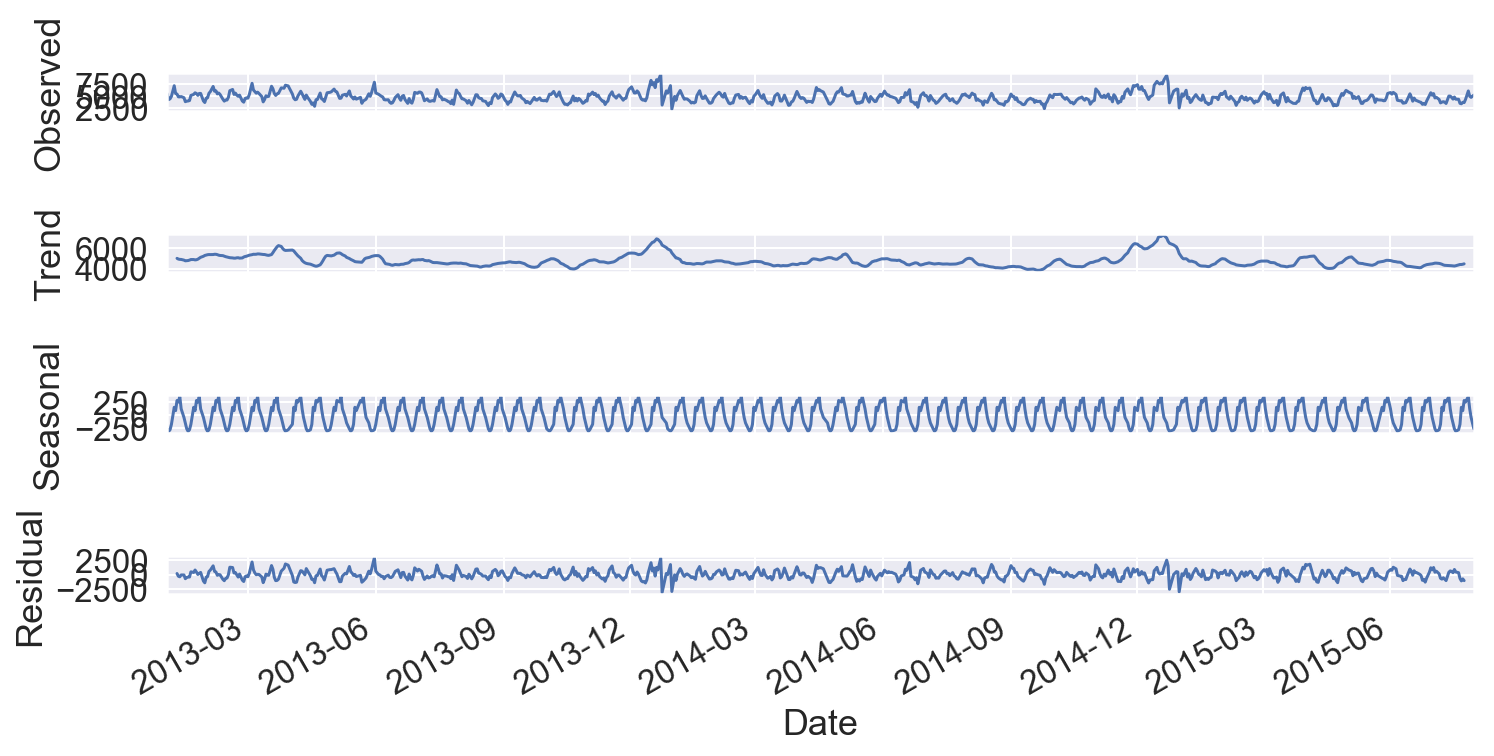

In [62]:
decomposition = seasonal_decompose(df.Sales, freq=12)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

## Plot the (partial) autocorrelations

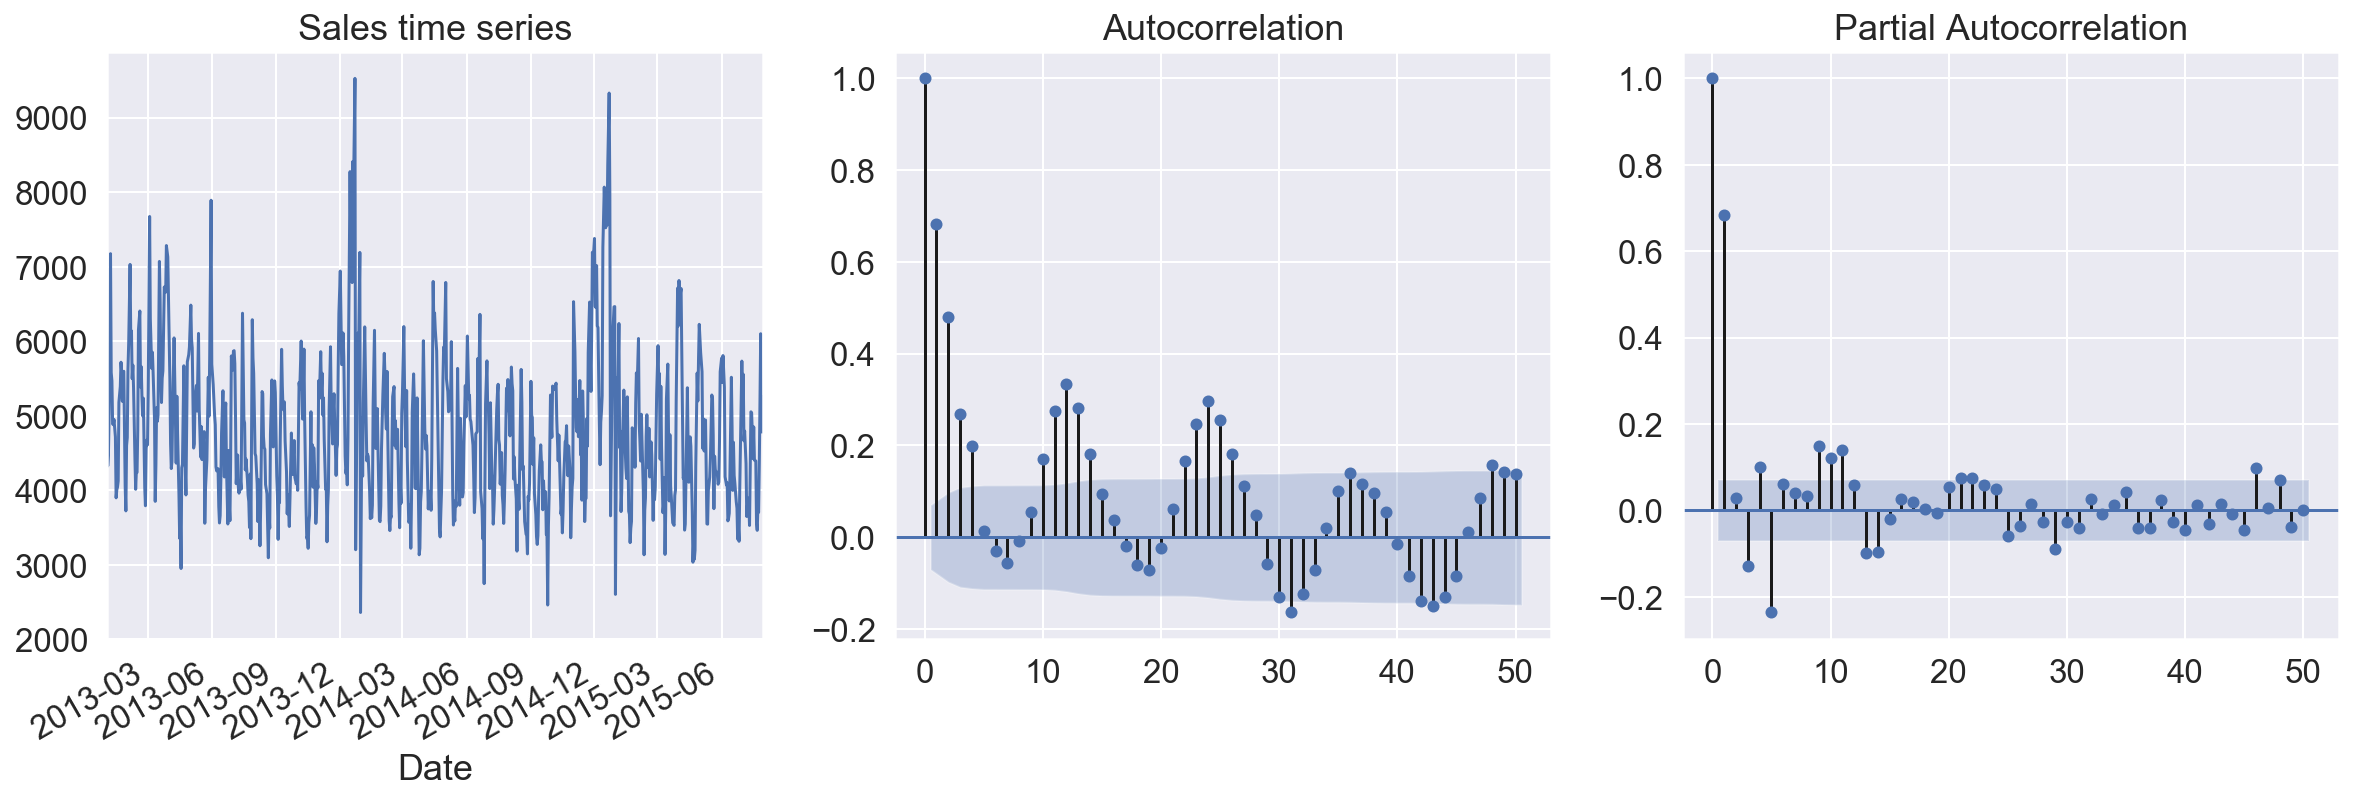

In [48]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
df['Sales'].plot(ax=ax[0], title='Sales time series')
plot_acf(df['Sales'], lags=50, ax=ax[1]) # lags here just extends the x-axis to display
plot_pacf(df['Sales'], lags=50, ax=ax[2])
plt.show()

# we can see clearly from the autocorrelation plots the periodicity, these plots tend to be more helpful for 
# confirming the frequency of periodicity than the above seasonal decomposition plots

## Fit a SARIMA model

- Fit and tune the model
- Provide plot diagnostics
- Produce in- and out-of-sample forecasts and plot
- Evaluate your model

/Users/Noah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Noah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Noah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Noah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Noah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

(5, 2)


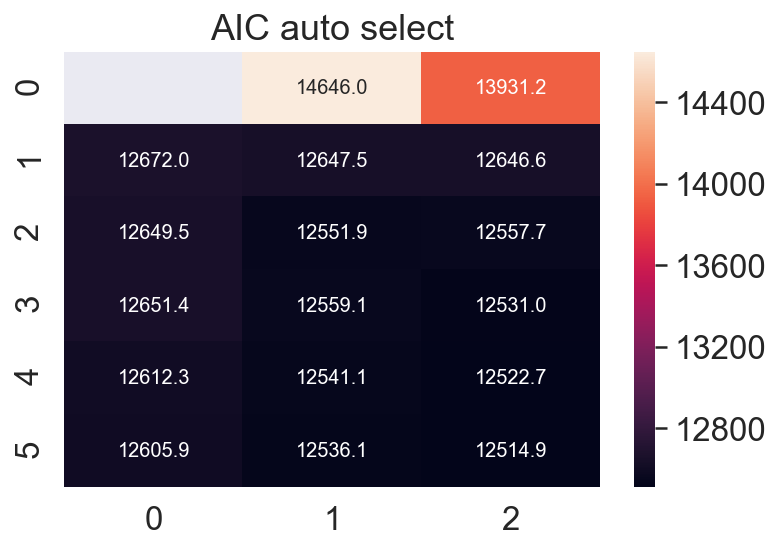

In [50]:
model = sm.tsa.arma_order_select_ic(df['Sales'],
                                          max_ar=5, max_ma=2, ic=['aic'],
                                          trend='nc',
                                          fit_kw={'method': 'css-mle',
                                                  'maxiter': 5000,
                                                  'solver': 'lbfgs'})

print(model.aic_min_order)

sns.heatmap(model['aic'], annot=True, fmt='.1f')
plt.ylim([model['aic'].shape[0], 0])
plt.title('AIC auto select')
plt.show()

In [69]:
model = sm.tsa.statespace.SARIMAX(df.Sales,
                                  order=(5, 0, 2),
                                  seasonal_order=(1, 1, 1, 6))
results = model.fit(maxiter=10000)
results.summary()

/Users/Noah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Noah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Noah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  781
Model:             SARIMAX(5, 0, 2)x(1, 1, 1, 6)   Log Likelihood               -6199.153
Date:                           Fri, 14 Feb 2020   AIC                          12418.306
Time:                                   12:21:36   BIC                          12464.835
Sample:                                        0   HQIC                         12436.207
                                           - 781                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8813      0.073     12.105      0.000       0.739       1.024
ar.L2         -0.4565      0.095     -4.799      0.000      -0.643      -0.270
ar.L3          0.1120      0.063      1.773      0.076      -0.012       0.236
ar.L4          0.2627      0.040      6.604      0.000       0.185       0.341
ar.L5         -0.4138      0.029    -14.408      0.000      -0.470      -0.358
ma.L1         -0.1949      0.075     -2.583      0.010      -0.343      -0.047
ma.L2          0.3668      0.073      5.029      0.000       0.224       0.510
ar.S.L6        0.3010      0.041      7.276      0.000       0.220       0.382
ma.S.L6       -0.9760      0.015    -63.672      0.000      -1.006      -0.946
sigma2      5.053e+05   1.66e+04     30.434      0.000    4.73e+05    5.38e+05
===================================================================================
Ljung-Box (Q):                       85.42   Jarque-Bera (JB):              1008.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.92
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

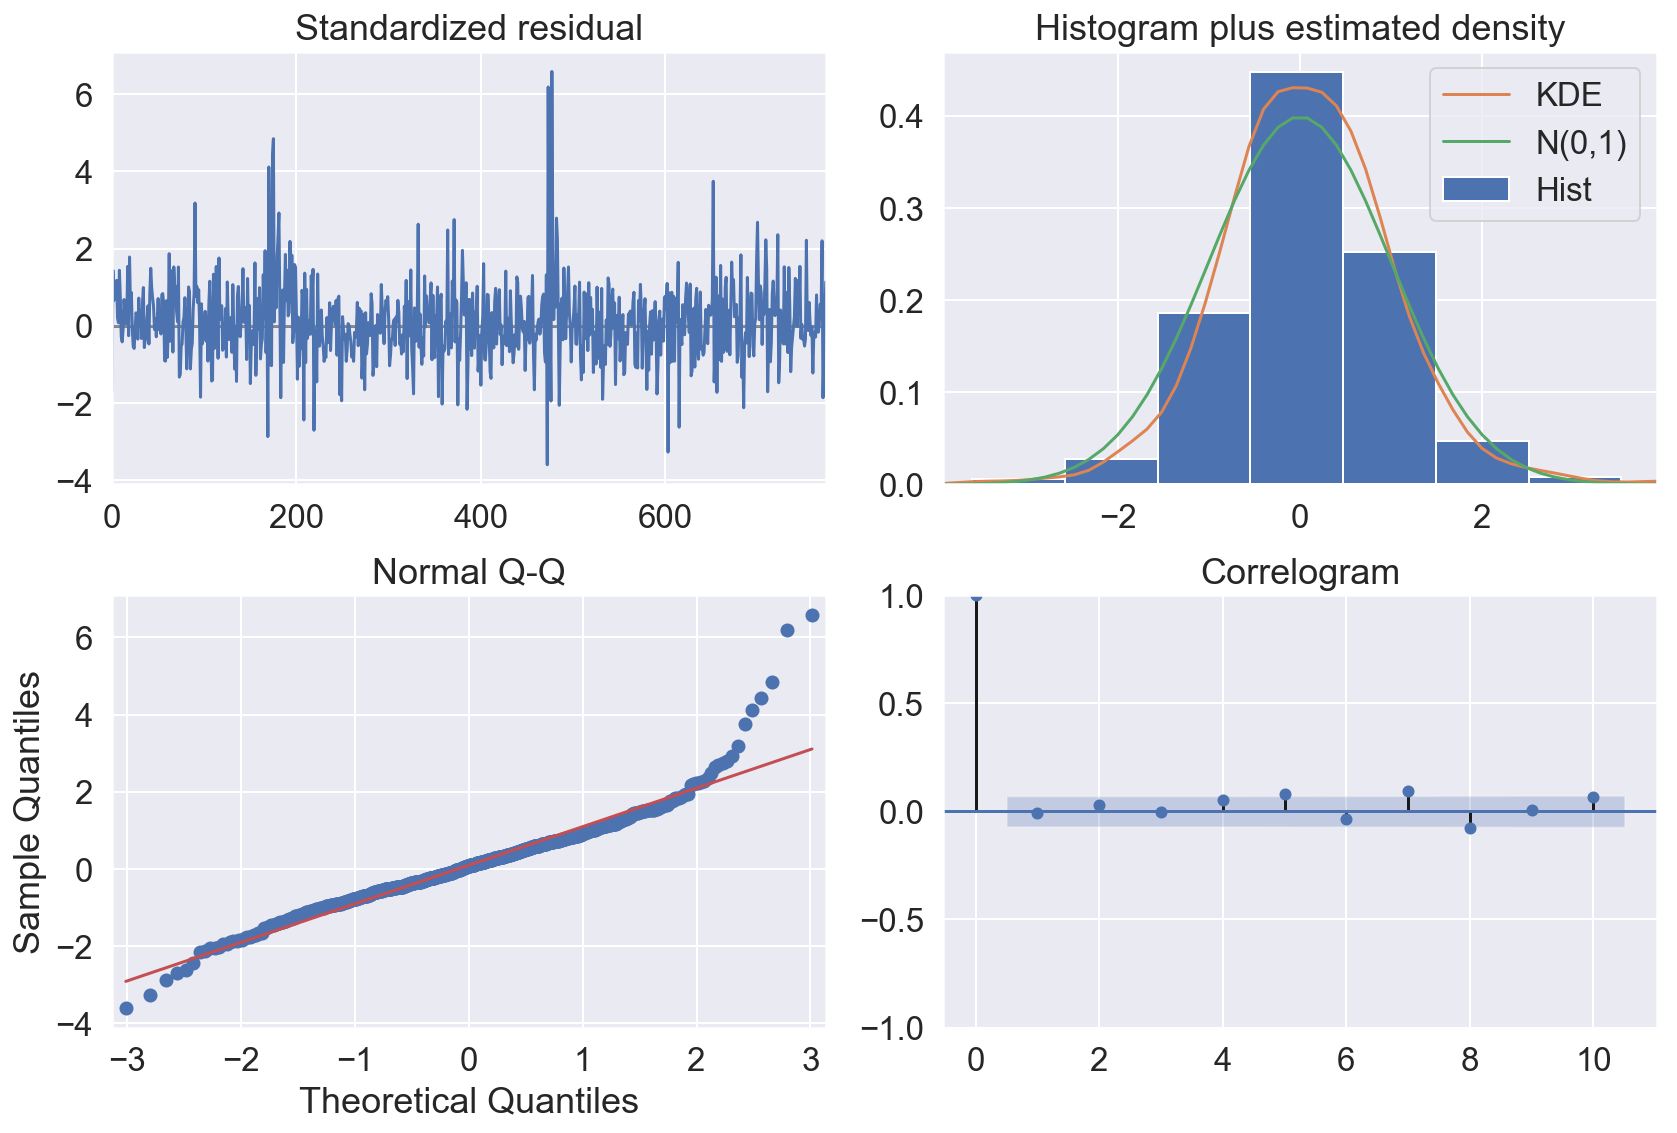

In [70]:
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [59]:
df.head(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1
2015-07-25,1,6,4364,500,1,0,0,0
2015-07-24,1,5,3706,459,1,0,0,0
2015-07-23,1,4,3769,503,1,0,0,0
2015-07-22,1,3,3464,463,1,0,0,0


In [58]:
df.tail(1)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1


In [108]:
start_p = 100

preds = results.predict(start=0, end=len(df)-1, dynamic=False)
preds.sort_index(inplace=True)
preds_dyn = results.predict(start=len(df)-start_p, end=len(df)-1, dynamic=True).sort_index(inplace=True)
preds_dyn.sort_index(inplace=True)

plt.figure(figsize=(10,10))
plt.plot(df.Sales, 'bo', preds, 'g--', preds_dyn, 'r-.')
plt.legend(['data', 'non-dynamical forecasting', 'dynamical forecasting'])
plt.show()

# cool thing about SARIMA is that it gives you proper values for the below prediction chart, not just plotting
# predicted diffs... so we would use SARIMA normally, not ARIMA due to this clarity (you can just set the 
# seasonal order to (0, 0, 0, 0) ie. the default and just tune for that)

AttributeError: 'NoneType' object has no attribute 'sort_index'

In [71]:
print(results.params.sigma2)
print(1-results.params.sigma2/df.Sales.var())

505332.21338203386
0.5066846289072993
